# Last Man Standing

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import footballdata as foo
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)
import pandas as pd
import itertools
import cvxpy as cvx

from matplotlib.pyplot import figure, show
import pprint as pp

In [ ]:
print(foo.MatchHistory.__doc__)

In [ ]:
foo.MatchHistory.available_leagues()

In [ ]:
prem = foo.MatchHistory('ENG-Premier League', range(2016, 2017)).read_games()
prem.sample(5)

In [ ]:
print(list(prem)) # columns of DataFrame

#### TODO check correct formula and explain going from odds $\rightarrow$ prob

In [ ]:
# odds are typically given for home team
def probs_from_odds(odds_win, odds_draw, odds_lose):
    prob_win, prob_draw, prob_lose = \
        map(lambda odds: odds / (1 + odds) , [odds_win, odds_draw, odds_lose])
    vig = prob_win + prob_draw + prob_lose - 1 # bookie's cut
    prob_win_normed, prob_draw_normed, prob_lose_normed = \
        map(lambda prob: prob / (1 + vig) , [prob_win, prob_draw, prob_lose])
    return prob_win_normed, prob_draw_normed, prob_lose_normed

In [ ]:
probs_from_odds(3.10, 3.30, 2.50)

In [ ]:
# Check seasons
prem_index = prem.index.get_values()
set([idx[1] for idx in prem_index])

In [ ]:
teams = list(prem.home_team.unique())
num_teams = len(teams)
print(teams)

## Winning probabilities matrix

What we want now is the matrix $X\in [0,1]^{38 \times 20}$, with elements defined by

$$X_{i,j} := p^{(i)}_j = \text{probability that team }j\text{ wins in week }i.$$

#### TODO Refactor to take odds from different bookies, maybe in `prob_from_odds`

In [ ]:
num_teams = len(teams)
X = np.zeros( (2 * (num_teams - 1), num_teams))
X_index = np.empty((2 * (num_teams - 1), num_teams), dtype=object)
games_played_by_team = np.zeros(len(teams), dtype=int) # array keeps track of how many games each team has played

for index, row in prem.iterrows():
    j_home = teams.index(row["home_team"])
    j_away = teams.index(row["away_team"])
    i_home = games_played_by_team[j_home]
    i_away = games_played_by_team[j_away]
    home_prob, draw_prob, away_prob = probs_from_odds(row["B365H"], row["B365D"], row["B365A"])
    X[i_home, j_home] = home_prob
    X[i_away, j_away] = away_prob
    X_index[i_home, j_home] = index
    X_index[i_away, j_away] = index
    games_played_by_team[j_home] += 1
    games_played_by_team[j_away] += 1
    

In [ ]:
print(np.where(X == 0))

In [ ]:
print(X[24,5])
print(X_index[24,5])
game = prem.loc[X_index[24,5]]
home_prob, draw_prob, away_prob = probs_from_odds(game["B365H"], game["B365D"], game["B365A"])
print(home_prob, draw_prob, away_prob)

The winning probabilities will be (very) small, even for the best ones. So let's use the $\log(\,\cdots\,)$ of the winning probability as our metric of 'goodness' for a strategy. 

In [ ]:
def evaluate_perm(perm_list, X):
    """
      Gives log of winning probability of a permutation
    """
    winning_probs = X[np.arange(len(perm_list)), np.array(perm_list)]
    return np.sum(np.log(winning_probs))

In [ ]:
def team_order_from_perm_list(perm_list, teams):
    """
        takes a list of integers and returns corresponding list of teams
    """
    ## check list 'full'
    if( not (sorted(perm_list) == list(range(len(perm_list))))):
        raise(ValueError("perm_list doesn't contain all integers from 0 to %d" % (len(perm_list) -1 )))
    team_choice = [teams[i] for i in perm_list]
    return team_choice

## Greedy strategy

First of all, let's do the most simple thing we can do: at each time, pick the team out of those you are allowed to with the highest winning probability for that week. We'll call this the *greedy strategy*.


In [ ]:
def greedy_strategy(X, teams):
    """
        Given winning probability matrix X returns the "greedy" strategy
        permutation of teams - given as a list of integers.
    """
    ## Check dims of X ok
    num_weeks = X.shape[0]
    num_teams = X.shape[1]
    if (num_teams != len(teams)):
        raise(ValueError("X needs to have %d rows, has %d." % (num_teams, X.shape[1])))
    # generate sample
    visited = []
    for t in list(range(min(num_teams, num_weeks))):
        allowed = [i for i in list(range(num_teams)) if i not in visited]
        probs = X[t, allowed] / np.sum(X[t, allowed])
        sample = allowed[np.argmax(probs)]
        visited.append(sample)
    return visited

In [ ]:
greedy_perm = greedy_strategy(X, teams)
greedy_strategy_result = {"opt_perm": greedy_perm, \
                          "opt_value": evaluate_perm(greedy_perm, X), \
                          "opt_team_list": team_order_from_perm_list(greedy_perm, teams)\
                         }
pp.pprint(greedy_strategy_result, compact=True)

So by our earlier reasoning, any permutation of teams we can find that is higher than `greedy_strategy_result["opt_value"]` is a success!

## Greedy sampling strategy

Now let's do the second simplest thing we can think of.

**Greedy sampling (GS). ** At each timestep $t$, look at the teams that haven't previously been chosen. Choose a team randomly, where the probability is weighted by the odds of that team winning in week $t$.

More formally, let $\mathcal{A}(t)$ be the set of vertices allowed at time $t$, i.e. those that have not been chosen in times $1,2,\ldots,t-1$. Then,

$$\mathbb{P}\{ \text{choose team }j \text{ at time } t\} = \frac{p^{(t)}_j}{\sum_{k \in \mathcal{A}(t)} p^{(t)}_k}. $$

Let's try and provide some rough theoretical justification for this method of generating permutations of teams (you can skip this part if you believe me that this is an OK thing to do).

---

Suppose we have have chosen the permutation $\sigma = (\sigma(1), \sigma(2), \ldots, \sigma(n))$ according to the greedy sampling scheme. The probability of choosing this permutation is

$$ \mathbb{P}_{\sigma \sim \text{GS}}(\sigma) = \frac{p^{(1)}_{\sigma(1)}}{\sum_{k \in [n]} p^{(1)}_{k}} \cdot \frac{p^{(2)}_{\sigma(2)}}{\sum_{k \in [n]\setminus \{\sigma(1)\}} p^{(2)}_{k}} \cdot \frac{p^{(3)}_{\sigma(3)}}{\sum_{k \in [n]\setminus \{\sigma(1), \sigma(2)\}} p^{(3)}_{k}} \cdot \cdots \cdot  \frac{p^{(n-1)}_{\sigma(n-1)}}{\sum_{k \in [n]\setminus \{\sigma(1), \sigma(2), \ldots, \sigma(n-2)\}} p^{(n-1)}_{k}} \cdot 1 .$$

We then have that

$$\mathbb{P}\{\sigma \text{ wins}\} = p^{(n)}_{\sigma(n)} \cdot \left( \sum_{k \in [n]\setminus \{\sigma(1), \sigma(2), \ldots, \sigma(n-2)\}} p^{(n-1)}_{k} \right) \cdot \cdots \cdot \left( \sum_{k \in [n]} p^{(1)}_{k} \right) \cdot \mathbb{P}_{\sigma \sim \text{GS}}(\sigma). $$

Let's consider two permutations $\sigma_A$ and $\sigma_B$ and take the ratio of the winning probabilities:

$$ \frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} = \frac{p^{(n)}_{\sigma_A(n)} \cdot \left( \sum_{k \in [n]\setminus \{\sigma_A(1), \sigma_A(2), \ldots, \sigma_A(n-2)\}} p^{(n-1)}_{k} \right) \cdot \cdots \cdot \left( \sum_{k \in [n]} p^{(1)}_{k} \right)}{ 
p^{(n)}_{\sigma_B(n)} \cdot \left( \sum_{k \in [n]\setminus \{\sigma_B(1), \sigma_B(2), \ldots, \sigma_B(n-2)\}} p^{(n-1)}_{k} \right) \cdot \cdots \cdot \left( \sum_{k \in [n]} p^{(1)}_{k} \right)
} \cdot \frac{\mathbb{P}_{\sigma_A \sim \text{GS}}(\sigma_A)}{\mathbb{P}_{\sigma_B \sim \text{GS}}(\sigma_B)} $$

That's a pretty hairy equation, so let's simplify with a bit of new notation: let $S_\sigma^{(t)} = [n]\setminus \{\sigma(1), \sigma(2), \ldots, \sigma(t)\}$ for $t\in\{0,1,\ldots, n\}$. Just to clarify:

$$S^{(n)}_\sigma = \emptyset, \ S^{(n-1)}_\sigma = \{ \sigma(n) \},\ \ldots, \ S^{1}_\sigma = [n] \setminus \{\sigma(1)\},\ S^{(0)}_\sigma = [n]$$

and $\left|S^{(t)}_\sigma\right| = n-t$.

Moreover, let's call the ratio 

$$ R^{(t)} = \frac{\sum_{k\in S^{(t -1 )}_{\sigma_A}} p_k^{(t)} } 
{\sum_{k\in S^{(t -1 )}_{\sigma_B}} p_k^{(t)}} $$

for $t \in \{1,\ldots, n\} $. We can now have the more succinct

$$
\frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} = \prod^{n}_{t=1}R^{(t)} \cdot \frac{\mathbb{P}_{\sigma_A \sim \text{GS}}(\sigma_A)}{\mathbb{P}_{\sigma_B \sim \text{GS}}(\sigma_B)} 
$$

Now for the dodgy bit: let's now assume that we choose the permutations $\sigma_A, \sigma_B \sim \operatorname{Uni}(\mathbb{S}_n)$, i.e. uniformly at random; and that the $p^{(i)}_j$ are independent and identically distributed on the open interval $(0,1)$. Moreover, define $\mu = \mathbb{E}[p^{(i)}_j]$. Let us try and estimate the quantity $\mathbb{E}\left[ \frac{1}{\prod^{n}_{t=1}R^{(t)}} \cdot \frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} \right]$ as a proxy for the ratio $\frac{\mathbb{P}_{\sigma_A \sim \text{GS}}(\sigma_A)}{\mathbb{P}_{\sigma_B \sim \text{GS}}(\sigma_B)}$. We then have


$$\mathbb{E}\left[ \frac{1}{\prod^{n}_{t=1}R^{(t)}} \cdot \frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} \right] = \mathbb{E}\left[ \prod^{n}_{t=1}R^{(t)} \cdot \frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} \right] = \mathbb{E}\left[ \prod^{n}_{t=1}R^{(t)}\right] \cdot \frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}}, $$

where we obtain the first equality by symmetry and the second from linearity of expectation.


Let's now take the expectation value of $\prod^{n}_{t=1}R^{(t)}$. By linearity of expectation, we have that

$$\mathbb{E} \left[ \prod^{n}_{t=1}R^{(t)} \right] = \prod^{n}_{t=1} \mathbb{E} \left[ R^{(t)}\right].$$

Now, 

$$ \mathbb{E} \left[ R^{(t)}\right] = \frac{1}{n!} \sum_{\sigma_A \in \mathbb{S}_n} \sum_{k \in S^{(t)}_{\sigma_A}} \mathbb{E}\left[ p^{(t)}_k \right] \cdot \frac{1}{n!} \sum_{\sigma_B \in \mathbb{S}_n}\frac{1}{ \sum_{k \in S^{(t)}_{\sigma_B}} \mathbb{E}\left[ p^{(t)}_k \right]} \\
= \frac{1}{n!} \sum_{\sigma_A \in \mathbb{S}_n} \sum_{k \in S^{(t)}_{\sigma_A}} \mu \cdot \frac{1}{n!} \sum_{\sigma_B \in \mathbb{S}_n} \frac{1}{\sum_{k \in S^{(t)}_{\sigma_B}} \mu} \\
\frac{1}{n!} \sum_{\sigma_A \in \mathbb{S}_n} (n-t) \mu \cdot \frac{1}{n!} \sum_{\sigma_B \in \mathbb{S}_n} \frac{1}{(n-t) \mu} = 1.
$$

So that means, under some somewhat shaky assumptions, we have

$$
\frac{\mathbb{P}_{\sigma_A \sim \text{GS}}(\sigma_A)}{\mathbb{P}_{\sigma_B \sim \text{GS}}(\sigma_B)} \approx
\frac{\mathbb{P}\{\sigma_A \text{ wins}\}}{\mathbb{P}\{\sigma_B \text{ wins}\}} , 
$$

so sampling permutations from the GS distribution hopefully gives us samples somewhat consistent with sampling permutations with probability proportional to their winning probabilities -- that is -- the permutation with the highest winning probability should be sampled with the highest probability according to GS.

In [ ]:
def greedy_sample(X, teams):
    """
        Given winning probability matrix X returns a "greedy" sample
        permutation of teams - given as a list of integers.
    """
    ## Check dims of X ok
    num_weeks = X.shape[0]
    num_teams = X.shape[1]
    if (num_teams != len(teams)):
        raise(ValueError("X needs to have %d rows, has %d." % (num_teams, X.shape[1])))
    # generate samples
    visited = []
    for t in list(range(min(num_teams, num_weeks))):
        allowed = [i for i in list(range(num_teams)) if i not in visited]
        probs = X[t, allowed] / np.sum(X[t, allowed])
        sample = np.random.choice(allowed, p=probs)
        visited.append(sample)
    return visited

In [ ]:
greedy_sample(X, teams)

### Take many greedy samples and save the best

In [ ]:
def greedy_sample_strategy(X, teams, num_iterations):
    optimal_sampled_perm = []
    optimal_value = -float("inf")
    optimal_t = 0
    for t in range(num_iterations - 1):
        if (t % 1000 == 0):
            print("Run %d of %d. Current optimal value is %.4f observed at run %d." \
                  % (t, num_iterations, optimal_value, optimal_t))
        sample = greedy_sample(X, teams)
        value = evaluate_perm(sample, X)
        if (value > optimal_value):
            optimal_value = value
            optimal_sampled_perm = sample[:]
            optimal_t = t
    return optimal_sampled_perm, optimal_value

In [ ]:
num_iterations = 1000000
greedy_opt_perm, greedy_opt_val = greedy_sample_strategy(X, teams, num_iterations)
greedy_sample_result = {"opt_perm": greedy_opt_perm, \
                        "opt_value": greedy_opt_val, \
                        "opt_team_list": team_order_from_perm_list(greedy_opt_perm, teams)\
                       }

In [ ]:
pp.pprint(greedy_sample_result, compact=True)

## Simulated Annealing Strategy

Common heuristic heuristic strategy for TSP, other combinatorial optimisation algorthms

### TODO discuss mixing, burn-in etc


In [ ]:
def metropolis_sample(X, teams, burn_in, start_perm, beta):
    """
    Returns a Metropolis-sampled permutation after `burn_in` steps, starting from `start_perm`.
    Acceptance probability ratio is winning probability ratio, beta is inverse temperature.
    """
    ## Check dims of X, start_perm ok
    num_weeks = X.shape[0]
    num_teams = X.shape[1]
    if (num_teams != len(teams)):
        raise(ValueError("X needs to have %d rows, has %d." % (num_teams, X.shape[1])))
    if( not (sorted(start_perm) == list(range(len(start_perm))))):
        raise(ValueError("start_perm doesn't contain all integers from 0 to %d" % (len(start_perm) -1 )))
    
    out_perm = start_perm[:]
    out_val = evaluate_perm(out_perm, X)
    for t in range(burn_in):
        idx1, idx2 = np.random.choice(len(teams), 2, replace=False)
        candidate_perm = out_perm[:]
        candidate_perm[idx1], candidate_perm[idx2] = candidate_perm[idx2], candidate_perm[idx1]
        candidate_val = evaluate_perm(candidate_perm, X)
        ratio = np.exp(candidate_val) / np.exp(out_val)  # evaluate_perm() is log of winnning probability
        
        accept = False
        if (ratio >= 1):
            accept = True
        else:
            accept = np.random.rand() <= np.exp(- beta * ratio)

        if (accept):
            # print("accept", t, candidate_val, out_val, (np.exp(candidate_val) / np.exp(out_val)), out_perm)
            out_perm = candidate_perm[:]
            out_val = candidate_val
            
    return out_perm, out_val        

In [ ]:
def simulated_anneal_sample(X, teams, burn_in, start_perm, beta_i, beta_f, alpha):
    """
    Return a permutation sample according to the simulated annealing algorithm, 
    starting at inverse temperature `beta_i` and stopping at `beta_f`. Beta geometrically
    increases, by a factor `alpha` at each step, `burn_in` runs at each temperature.
    """
    current_perm = start_perm
    beta = beta_i
    while (beta <= beta_f):
        beta = alpha * beta
        out_perm, out_val = metropolis_sample(X, teams, burn_in, current_perm, beta)
        current_perm = out_perm[:]
    return out_perm, out_val    

In [ ]:
def simulated_anneal_sample_strategy(X, teams, burn_in, start_perm, beta_i, beta_f, alpha, num_runs):
    """
    Return the permutation giving the maximum winning probability after `num_samples`
    SA samples.
    """
    optimal_perm = start_perm[:]
    optimal_val = evaluate_perm(optimal_perm, X)
    for t in range(num_runs):
        if (t % 5 == 0):
            print("Run %d of %d. Current optimal value is %.4f." \
                  % (t + 1, num_runs, optimal_val))
        sample_perm, sample_val = simulated_anneal_sample(X, teams, burn_in, start_perm, beta_i, beta_f, alpha)
        if (sample_val > optimal_val):
            optimal_val = sample_val
            optimal_perm = sample_perm[:]
    return optimal_perm, optimal_val    

In [ ]:
# Quick test

alpha = 1.03
beta_i = 0.1
beta_f = 50
burn_in = 200
start_perm = greedy_perm
num_runs = 20

SA_opt_perm, SA_opt_val = simulated_anneal_sample_strategy(X, teams, burn_in, stddart_perm, beta_i, beta_f, alpha, num_runs)

### Tune the hyperparameters

Here we're going to use a very naive method: grid search. Let's fix some of the hyperparameters to sensible values to not have to test too many combinations of values. These include the final inverse temperature $\beta_f= 50$ and the `burn_in=200`. We'll set $\beta_f = 50$ because $e^{-50}$ is *tiny* so more or less zero acceptance probability for any transition lowering the energy and `burn_in=200` since it is roughly the number of possible transitions from a given state $n(n-1)/2$. We'll use the greedy stategy as a starting state.

We *are* going to vary the initial inverse temperature $\beta_i$ and the multiplier, $\alpha$.

We'll give each of the $(\beta_i, \alpha)$ pairs 25 goes to show us what they're made of. The best pair will then be used for many more runs to give us the SA strategy generated permutation. 



In [ ]:
beta_f = 50
burn_in = 200
start_perm = greedy_perm
num_runs = 25

alphas = [1.02, 1.05, 1.1, 1.15, 1.2]
beta_is = [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5]

SA_hyperparam_results = pd.DataFrame(columns = ['alpha', 'beta_i', 'SA_opt_val', 'SA_opt_perm'])

for alpha, beta_i in itertools.product(alphas, beta_is):
    print("Testing alpha = %.3f, beta_i = %.4f " % (alpha, beta_i))
    SA_opt_perm, SA_opt_val = \
            simulated_anneal_sample_strategy(X, teams, burn_in, start_perm, beta_i, beta_f, alpha, num_runs)
    SA_hyperparam_results = SA_hyperparam_results.append({'alpha': alpha, 'beta_i': beta_i, 'SA_opt_val': SA_opt_val, 'SA_opt_perm': SA_opt_perm},\
                                ignore_index=True)    

In [ ]:
SA_hyperparam_results.iloc[SA_hyperparam_results['SA_opt_val'].idxmax()]

In [ ]:
beta_f = 50
burn_in = 200
start_perm = greedy_perm
num_runs = 200
alpha = 1.1
beta_i = 0.01

SA_opt_perm, SA_opt_val = \
        simulated_anneal_sample_strategy(X, teams, burn_in, start_perm, beta_i, beta_f, alpha, num_runs)

In [ ]:
SA_sample_result = {"opt_perm": SA_opt_perm, \
                    "opt_value": SA_opt_val, \
                    "opt_team_list": team_order_from_perm_list(SA_opt_perm, teams)\
                    }
pp.pprint(SA_sample_result, compact=True)

### Determine "nice" `burn_in`

Discuss Lehvenshtein 'edit distance' - relation transposition distance

In [ ]:
import editdistance

In [ ]:
burn_ins = np.arange(10, 5000, 10)
num_trials = 50
distance_arr = np.zeros(burn_ins.shape)
std_arr = np.zeros(burn_ins.shape)
for idx, _ in enumerate(burn_ins):
    distances = np.zeros(num_trials)
    for trial in range(num_trials):
        sampled_perm, _ = metropolis_sample(X, teams, burn_in, greedy_perm)
        distances[trial] = editdistance.eval(sampled_perm, greedy_perm)
    distance_arr[idx] = np.mean(distances)
    std_arr[idx] = np.std(distances) / np.sqrt(num_trials)

In [ ]:
plt.figure()
plt.errorbar(burn_ins, distance_arr, yerr=std_arr, fmt='o')
plt.xlabel("burn-in steps")
plt.ylabel("edit distance from initial step")
plt.title("Determine number of burn-in steps required");

## Convex Programming Strategy

Let $\tilde{X}$ be the matrix with entries given by

$$[\tilde{X}]_{i,j} = \ln X_{i,j} = \ln p^{(i)}_j$$

Now consider the optimisation problem

$$ \arg\max_{\sigma \in \mathbb{S}_n} \operatorname{Tr}(P_{\sigma} \tilde{X} )$$

The solution to this problem is 

### TODO: convex relaxation

### Permutation matrices

In [ ]:
from birkhoff import to_permutation_matrix as to_permutation_matrix
def perm_matrix_from_list(perm_list):
    """
        Takes an ordered list of integers and returns a permutation matrix.
    """
    ## check list 'full'
    n_range = list(range(len(perm_list)))
    if( not (sorted(perm_list) == n_range)):
        raise(ValueError("perm_list doesn't contain all integers from 0 to %d" % (len(perm_list) -1 )))
    perm_dict = dict(zip(n_range, perm_list))    
    return to_permutation_matrix(perm_dict) 

In [112]:
X_tilde = np.log(X)[0:len(teams), 0:len(teams)]

P = cvx.Variable(*X_tilde.shape)
W = cvx.Parameter(*X_tilde.shape, sign="negative")
W.value = X_tilde
obj = cvx.Maximize(cvx.trace(W*P))

constraints = [0 <= P, P <= 1]

col_sums = cvx.sum_entries(P, axis=0) 
row_sums = cvx.sum_entries(P, axis=1)

for col_sum in col_sums:
    constraints += [col_sum == 1]

for row_sum in row_sums:
    constraints += [row_sum == 1]

prob = cvx.Problem(obj, constraints)
prob.solve()

print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -19.456730722494175


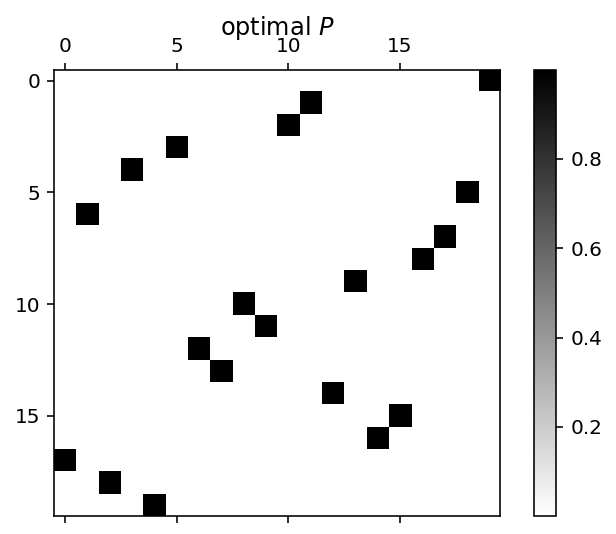

In [127]:
#pp.pprint(P.value, compact=True)
plt.figure(num=1, figsize=(6, 4))
plt.matshow(P.value, cmap="binary", fignum=1)
plt.colorbar();
plt.title("optimal $P$");

In [114]:
rounded = np.rint(np.asarray(P.value))

# check if permutation
assert(np.all(np.sum(rounded, 0)) == True)
assert(np.all(np.sum(rounded, 1)) == True)

# convert permutation matrix to perm_list
cvx_opt_perm = list(np.where(rounded.T == 1)[1])

cvx_result = {"opt_perm": cvx_opt_perm, \
              "opt_value": evaluate_perm(cvx_opt_perm, X), \
              "opt_team_list": team_order_from_perm_list(cvx_opt_perm, teams) \
              }

pp.pprint(cvx_result, compact=True)

{'opt_perm': [17, 6, 18, 4, 19, 3, 12, 13, 10, 11, 2, 1, 14, 9, 16, 15, 8, 7, 5,
              0],
 'opt_team_list': ['Sunderland', 'Southampton', 'West Ham United',
                   'Manchester City', 'Liverpool', 'Hull City', 'Stoke City',
                   'Swansea City', 'Manchester United', 'Leicester City',
                   'Everton', 'Crystal Palace', 'Tottenham Hotspur', 'Chelsea',
                   'West Bromwich Albion', 'Watford', 'Arsenal',
                   'AFC Bournemouth', 'Middlesbrough', 'Burnley'],
 'opt_value': -19.45673066562512}


In [88]:
result = decomp(np.asarray(P.value))
for coefficient, permutation_matrix in result:
    print('coefficient:', coefficient)
    print('permutation matrix:', permutation_matrix)

IndexError: index 19 is out of bounds for axis 0 with size 19

In [92]:
from birkhoff import birkhoff_von_neumann_decomposition as decomp
D = np.array([[0.999, 0.001], [0.001, 0.999]])
zipped_pairs = decomp(D)
coefficients, permutations = zip(*zipped_pairs)
coefficients

(0.999, 0.001)

In [101]:
decomp(np.asarray(P.value))

IndexError: index 19 is out of bounds for axis 0 with size 19

In [104]:
np.save("dub_stoch.npy", np.asarray(P.value))
